In [ ]:
import tensorflow as tf
import pandas as pd 
import os 
import pickle
import typing as tp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [ ]:
df: pd.DataFrame = pd.read_pickle(os.path.join('..', 'data', 'SemesterProject', 'processed_data.pkl'))
df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X: np.ndarray = np.stack(df['reshaped_skeleton'].values)
y: np.ndarray = df['movement_id'].values - 1    

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
batch_size: int = 64
n_time_frames: int = X.shape[1]
    

In [ ]:
a = (X_train - X_train.min())
a.min(), X_train.min(), X_train.max(), a.max()


In [ ]:
# Clear the session
tf.keras.backend.clear_session()

norm_layer = tf.keras.layers.Normalization(axis=None)
norm_layer.adapt(X_train)

a: np.ndarray = X_train - X_train.min()

scale_inv: float = a.max()
offset: float = X_train.min()

rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1, offset=-offset),
    tf.keras.layers.Rescaling(scale=1.0/scale_inv)])

scaled_data = rescale_layer(X_train)
print(f'Min {scaled_data.numpy().min()} / Max {scaled_data.numpy().max()}')

normed_data = norm_layer(X_train)
print(f'Mean {normed_data.numpy().mean()} / Std {normed_data.numpy().std()}')

# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(n_time_frames, 22, 3)),
#     norm_layer,
    
#     tf.keras.layers.ConvLSTM1D(filters=16, kernel_size=3, return_sequences=True),
#     tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=3, return_sequences=True),
# #     tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=5, return_sequences=True),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D()),
# #     tf.keras.layers.Reshape((n_time_frames, -1)),
    
#     tf.keras.layers.LSTM(units=32, return_sequences=False),
# #     tf.keras.layers.LSTM(units=64, return_sequences=False),
#     tf.keras.layers.Dense(units=16),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=10, activation='softmax')
# ])

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_time_frames, 22, 3)),
    norm_layer,
    tf.keras.layers.Reshape((n_time_frames, -1)),
    tf.keras.layers.LSTM(units=64, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.summary()

In [ ]:
n_epochs: int = 40

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..', 'models', 'pt-exercise-detector-best.mdl'), save_best_only=True, save_weights_only=True, initial_value_threshold=.7, verbose=1, monitor='val_accuracy')
    
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

In [ ]:
history_df: pd.DataFrame = pd.DataFrame.from_dict(history.history)
history_df['epoch'] = history_df.index.values

total_num_epochs: int = history_df.shape[0]

history_df.describe()

In [ ]:
val_df: pd.DataFrame = history_df[['epoch', 'val_accuracy', 'val_loss']].copy().rename({'val_accuracy': 'accuracy', 'val_loss': 'loss'}, axis=1)
val_df['stage'] = 'validation'
train_df: pd.DataFrame = history_df[['epoch', 'accuracy', 'loss']].copy()
train_df['stage'] = 'training'

results_df: pd.DataFrame = pd.concat([val_df, train_df], ignore_index=True)
results_df.head()

In [ ]:
plt.clf()
ax = sns.relplot(data=results_df, x='epoch', y='accuracy', hue='stage', kind='line')
plt.show()

In [ ]:
plt.clf()
ax = sns.relplot(data=results_df, x='epoch', y='loss', hue='stage', kind='line')
plt.show()

Seems like an epoch of 40 is good enough.

In [66]:
val_df: pd.DataFrame = history_df[['epoch', 'val_accuracy', 'val_loss']].copy().rename({'val_accuracy': 'accuracy', 'val_loss': 'loss'}, axis=1)
val_df['stage'] = 'validation'
train_df: pd.DataFrame = history_df[['epoch', 'accuracy', 'loss']].copy()
train_df['stage'] = 'training'

results_df: pd.DataFrame = pd.concat([val_df, train_df], ignore_index=True)
results_df.head()

,epoch,accuracy,loss,stage
0,0,0.065,2.305233,validation
1,1,0.065,2.300239,validation
2,2,0.140,2.269779,validation
3,3,0.235,2.184728,validation
4,4,0.175,2.098760,validation


<Figure size 825x587.5 with 0 Axes>

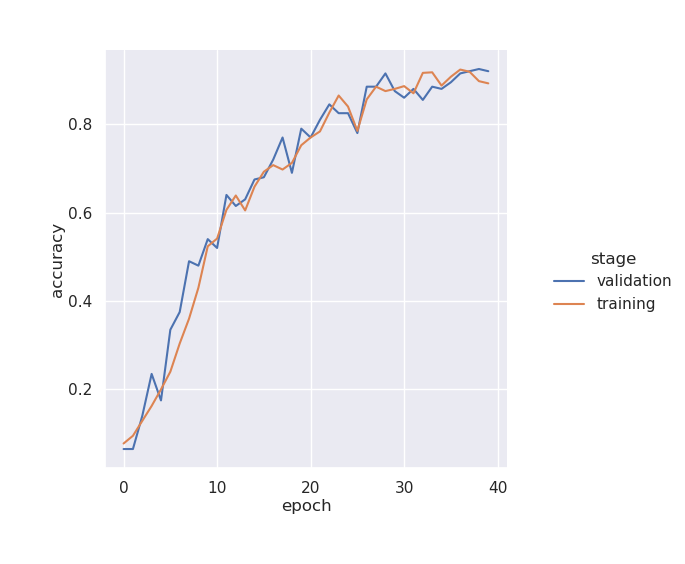

In [67]:
plt.clf()
ax = sns.relplot(data=results_df, x='epoch', y='accuracy', hue='stage', kind='line')
plt.show()

<Figure size 825x587.5 with 0 Axes>

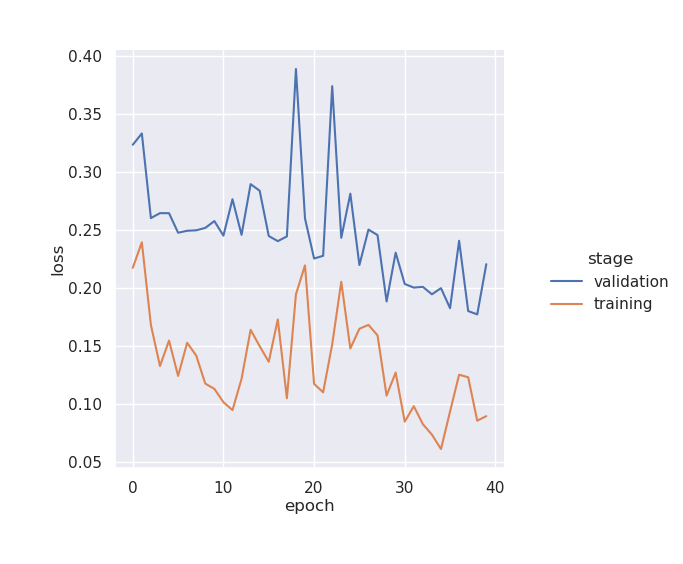

In [58]:
plt.clf()
ax = sns.relplot(data=results_df, x='epoch', y='loss', hue='stage', kind='line')
plt.show()

Seems like an epoch of 40 is good enough.